In [1]:
import pandas as pd
import gzip
import os
import numpy as np
from dtaidistance import dtw
from sklearn.cluster import KMeans
from scipy.spatial.distance import euclidean

In [2]:
####################################################
############# Setear segun cada maquina ############
#os.chdir("C:/Users/herna/labo3_empresa3_repo/datasets")
#os.chdir("C:/diego_tools/labo3/dataset")
ruta_dataset = "/home/lumamdq/buckets/b1/datasets/"
####################################################

In [3]:
Semestre = "4"

In [4]:
from datetime import datetime, timedelta
from datetime import datetime
from dateutil.relativedelta import relativedelta

# Fecha en formato string
if Semestre == "1":
    date_target = '2019-03-01'
elif Semestre == "2":
    date_target = '2019-06-01'
elif Semestre == "3":
    date_target = '2019-09-01'
else:
    date_target = '2019-12-01'

resta = 20

# Convertir la fecha a un objeto datetime
date_target_obj = datetime.strptime(date_target, '%Y-%m-%d')

# Calcular date_to_split (dos meses antes)
date_target_mas2 = (date_target_obj - timedelta(days=1)).replace(day=1) - relativedelta(months=-2)

# Calcular date_tn_menos_uno (un mes antes)
date_tn_menos_seis= (date_target_obj - timedelta(days=1)).replace(day=1) - relativedelta(months=1)

date_target_mas2 = date_target_mas2.strftime('%Y-%m-%d')
date_tn_menos_seis = date_tn_menos_seis.strftime('%Y-%m-%d')
# Imprimir resultados
print("date_target_mas2:", date_target_mas2)
print("date_target:", date_target)
print("date_tn_menos_seis:", date_tn_menos_seis)

date_target_mas2: 2020-01-01
date_target: 2019-12-01
date_tn_menos_seis: 2019-10-01


In [5]:
arch_prod_ids_prediccion = ruta_dataset+"productos_a_predecir.csv"
arch_base = ruta_dataset+"emp3_sellout_producto_base.csv"

In [6]:
#################################
###### Variables Generales ######
num_lags = 2

In [7]:
df = pd.read_csv(arch_base)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34707 entries, 0 to 34706
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   product_id                 34707 non-null  int64  
 1   periodo                    34707 non-null  int64  
 2   product_id_tn              34707 non-null  float64
 3   cero_ventas                34707 non-null  int64  
 4   cust_request_qty           34707 non-null  int64  
 5   cust_request_tn            34707 non-null  float64
 6   mes                        34707 non-null  int64  
 7   producto_estrella          34707 non-null  int64  
 8   plan_precios_cuidados      34707 non-null  int64  
 9   meses_historia_prod        34707 non-null  int64  
 10  cat1                       34707 non-null  object 
 11  cat2                       34707 non-null  object 
 12  cat3                       34707 non-null  object 
 13  sku_size                   34707 non-null  int

**tomo seis meses de historia para analizar los comportamientos de ventas**

In [8]:
date_tn_menos_seis = datetime.strptime(date_tn_menos_seis, '%Y-%m-%d')
date_tn_menos_seis = int(date_tn_menos_seis.strftime('%Y%m'))
df = df[df['periodo'] >= date_tn_menos_seis]
df.head(10)

,product_id,periodo,product_id_tn,cero_ventas,cust_request_qty,cust_request_tn,mes,producto_estrella,plan_precios_cuidados,meses_historia_prod,...,sku_size,temp_media,temp_min_media,temp_max_media,IPC,promedio_mens_dolar_venta,catastrofe,Cluster_dtw_1,Cluster_dtw_2,Cluster_dtw_3
32,20001,201910,1561.50552,0,367,1587.87525,10,1,0,33,...,3000,17.8,13.0,22.0,3.3,58.54,False,Cluster_2,Cluster_4,Cluster_2
33,20001,201911,1397.37231,0,392,1446.07905,11,1,0,34,...,3000,22.9,17.6,27.8,4.3,59.75,False,Cluster_2,Cluster_4,Cluster_2
34,20001,201912,1504.68856,0,407,1650.46149,12,1,0,35,...,3000,24.0,18.0,29.5,3.7,59.88,False,Cluster_2,Cluster_4,Cluster_2
67,20002,201910,1979.53635,0,312,2013.36305,10,1,0,33,...,3000,17.8,13.0,22.0,3.3,58.54,False,Cluster_2,Cluster_4,Cluster_3
68,20002,201911,1423.57739,0,590,1524.53293,11,1,0,34,...,3000,22.9,17.6,27.8,4.3,59.75,False,Cluster_2,Cluster_4,Cluster_3
69,20002,201912,1087.30855,0,217,1091.94005,12,1,0,35,...,3000,24.0,18.0,29.5,3.7,59.88,False,Cluster_2,Cluster_4,Cluster_3
102,20003,201910,1081.36645,0,404,1091.94793,10,1,0,33,...,475,17.8,13.0,22.0,3.3,58.54,False,Cluster_1,Cluster_1,Cluster_3
103,20003,201911,948.29393,0,351,996.01433,11,1,0,34,...,475,22.9,17.6,27.8,4.3,59.75,False,Cluster_1,Cluster_1,Cluster_3
104,20003,201912,892.50129,0,314,969.99507,12,1,0,35,...,475,24.0,18.0,29.5,3.7,59.88,False,Cluster_1,Cluster_1,Cluster_3
137,20004,201910,1064.69633,0,508,1078.32756,10,1,0,33,...,240,17.8,13.0,22.0,3.3,58.54,False,Cluster_1,Cluster_1,Cluster_3


**solo dejo los productos a precedir**

In [9]:
df_prods_prediccion=pd.read_csv(arch_prod_ids_prediccion)
df_prods_prediccion.head()

,product_id
0,20480
1,20481
2,20482
3,20483
4,20484


In [10]:
df = df[(df.product_id.isin(df_prods_prediccion.product_id))]

**genero 6 lags, que sera la serie de tiempo a analizar para clustering**

In [11]:
# Seleccionar las columnas 'periodo', 'product_id', 'customer_id' y 'tn'
df = df[['periodo', 'product_id', 'product_id_tn']]
df.rename(columns={'product_id_tn': 'tn'}, inplace=True)
df.head(10)

,periodo,product_id,tn
32,201910,20001,1561.50552
33,201911,20001,1397.37231
34,201912,20001,1504.68856
67,201910,20002,1979.53635
68,201911,20002,1423.57739
69,201912,20002,1087.30855
102,201910,20003,1081.36645
103,201911,20003,948.29393
104,201912,20003,892.50129
137,201910,20004,1064.69633


In [12]:
# Lags para product_id
for i in range(1, num_lags + 1):
    df[f'tn_lag_{i}'] = df.groupby(['product_id'])['tn'].shift(i)

In [13]:
date_target = datetime.strptime(date_target, '%Y-%m-%d')
date_target = int(date_target.strftime('%Y%m'))
df = df[df['periodo'] == date_target]

In [14]:
# Columnas a llenar con ceros
cols_to_fill = ['tn', 'tn_lag_1', 'tn_lag_2']
df[cols_to_fill] = df[cols_to_fill].fillna(0)
df.head()

,periodo,product_id,tn,tn_lag_1,tn_lag_2
34,201912,20001,1504.68856,1397.37231,1561.50552
69,201912,20002,1087.30855,1423.57739,1979.53635
104,201912,20003,892.50129,948.29393,1081.36645
139,201912,20004,637.90002,723.94206,1064.69633
174,201912,20005,593.24443,606.91173,996.78275


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 868 entries, 34 to 33872
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   periodo     868 non-null    int64  
 1   product_id  868 non-null    int64  
 2   tn          868 non-null    float64
 3   tn_lag_1    868 non-null    float64
 4   tn_lag_2    868 non-null    float64
dtypes: float64(3), int64(2)
memory usage: 40.7 KB


**tomo las distancias de todos los registros para despues aplicar clustering**

In [16]:
# Crear campo serie_cero para excluirlos del analisis
#df['serie_cero'] = 'N'
#mask = (df[['tn', 'tn_lag_1', 'tn_lag_2', 'tn_lag_3', 'tn_lag_4', 'tn_lag_5']] == 0).all(axis=1)
#df.loc[mask, 'serie_cero'] = 'Y'

In [17]:
#solo me quedo con aquellas series distintas a todo cero
#df_serie = df[df['serie_cero'] == 'N']
df_serie = df.copy()
# Suponiendo que tu DataFrame se llama 'df'
columns_to_convert = ['tn', 'tn_lag_1', 'tn_lag_2']
# Convertir las columnas seleccionadas a enteros
#df_serie[columns_to_convert] = df_serie[columns_to_convert].astype('int16')
df_serie.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 868 entries, 34 to 33872
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   periodo     868 non-null    int64  
 1   product_id  868 non-null    int64  
 2   tn          868 non-null    float64
 3   tn_lag_1    868 non-null    float64
 4   tn_lag_2    868 non-null    float64
dtypes: float64(3), int64(2)
memory usage: 40.7 KB


In [18]:
#busco un punto de corte para aquellos tn grandes
df_serie.describe()

,periodo,product_id,tn,tn_lag_1,tn_lag_2
count,868.0,868.000000,868.000000,868.000000,868.000000
mean,201912.0,20523.485023,27.859340,35.561545,39.295149
std,0.0,343.002643,90.645767,103.613636,124.421647
min,201912.0,20001.000000,0.000000,0.000000,0.000000
25%,201912.0,20230.750000,0.441410,0.717075,0.840337
50%,201912.0,20478.500000,4.103500,5.465715,6.772870
75%,201912.0,20790.750000,17.509943,23.035985,25.091287
max,201912.0,21271.000000,1504.688560,1423.577390,1979.536350


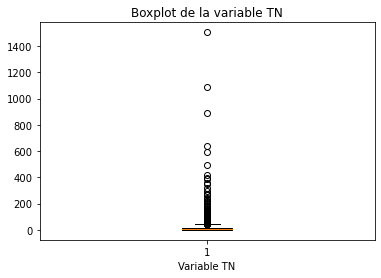

In [19]:
import matplotlib.pyplot as plt
# Graficar el boxplot
plt.figure(figsize=(6, 4))
plt.boxplot(df_serie['tn'])
plt.title('Boxplot de la variable TN')
plt.xlabel('Variable TN')
plt.show()


In [20]:
# Valor de corte
cutoff_value = 0
# Contar cuántos valores son mayores que el corte
count_greater_than_cutoff = sum(1 for value in df_serie['tn'] if value >= cutoff_value)
print(f"Registros mayores que {cutoff_value}: {count_greater_than_cutoff}")

Registros mayores que 0: 868


In [21]:
df_serie = df_serie[df_serie['tn'] >= cutoff_value]
df_serie.describe()

,periodo,product_id,tn,tn_lag_1,tn_lag_2
count,868.0,868.000000,868.000000,868.000000,868.000000
mean,201912.0,20523.485023,27.859340,35.561545,39.295149
std,0.0,343.002643,90.645767,103.613636,124.421647
min,201912.0,20001.000000,0.000000,0.000000,0.000000
25%,201912.0,20230.750000,0.441410,0.717075,0.840337
50%,201912.0,20478.500000,4.103500,5.465715,6.772870
75%,201912.0,20790.750000,17.509943,23.035985,25.091287
max,201912.0,21271.000000,1504.688560,1423.577390,1979.536350


In [22]:
df_serie.count()

periodo       868
product_id    868
tn            868
tn_lag_1      868
tn_lag_2      868
dtype: int64

In [23]:
# Seleccionar las columnas relevantes
time_series_df = df_serie[['tn', 'tn_lag_1', 'tn_lag_2']]
# Obtener las series temporales
time_series_list = time_series_df.values.tolist()
len(time_series_list)

868

In [24]:
# Función para calcular las distancias DTW
def calculate_dtw(series1, series2):
    distance = dtw.distance(series1, series2)
    return distance
print('comienzo')
# Calcular matriz de distancias DTW
n = len(time_series_list)

# Definir el número de divisiones
num_divisions = 10
division_size = n // num_divisions

# Lista para almacenar los DataFrames de las divisiones
dfs = []

# Iterar para generar las divisiones y guardarlas en archivos CSV
for i in range(num_divisions):
    start = i * division_size
    end = start + division_size if i < num_divisions - 1 else n

    division = np.zeros((end - start, n))
    
    for j in range(start, end):
        for k in range(n):
            division[j - start][k] = calculate_dtw(time_series_list[j], time_series_list[k])
            
            # Print cada 500 iteraciones
            if (j - start) % 100 == 0 and k == 0:
                print(f"Progreso - Iteración {i + 1}: {j - start}/{end - start}")

    df_division = pd.DataFrame(division)
    df_division.to_csv(ruta_dataset + f'division_{i}.csv', index=False)
    dfs.append(df_division)

# Concatenar todos los archivos CSV
final_df = pd.concat(dfs)
final_df.to_csv(ruta_dataset + 'final_distance_matrix.csv', index=False)

comienzo
Progreso - Iteración 1: 0/86
Progreso - Iteración 2: 0/86
Progreso - Iteración 3: 0/86
Progreso - Iteración 4: 0/86
Progreso - Iteración 5: 0/86
Progreso - Iteración 6: 0/86
Progreso - Iteración 7: 0/86
Progreso - Iteración 8: 0/86
Progreso - Iteración 9: 0/86
Progreso - Iteración 10: 0/94


In [25]:
#dataframe final con las distancias tomadas
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 868 entries, 0 to 93
Columns: 868 entries, 0 to 867
dtypes: float64(868)
memory usage: 5.8 MB


In [26]:
final_df.head()

,0,1,2,3,4,5,6,7,8,9,...,858,859,860,861,862,863,864,865,866,867
0,0.000000,591.305804,898.319638,1204.844407,1332.092391,1801.538706,1888.903358,1986.292457,1581.145323,1845.947660,...,2579.705419,2579.701449,2579.708679,2579.693996,2579.699496,2579.725089,2579.700274,2579.701357,2579.704641,2579.712114
1,591.305804,0.000000,990.501100,1140.057503,1273.906889,1898.292241,1993.770403,2044.861328,1698.030973,1944.252369,...,2669.684889,2669.674528,2669.688951,2669.668004,2669.678504,2669.702573,2669.680385,2669.680715,2669.681083,2669.688370
2,898.319638,990.501100,0.000000,327.202433,424.996039,912.569715,1002.598073,1088.854203,699.797093,954.955093,...,1692.651617,1692.646451,1692.655150,1692.639323,1692.645615,1692.671121,1692.646777,1692.647487,1692.650398,1692.657758
3,1204.844407,1140.057503,327.202433,0.000000,142.486751,656.835381,760.820148,823.106876,528.368212,721.630237,...,1436.837658,1436.826923,1436.841583,1436.820109,1436.831173,1436.855092,1436.832815,1436.833517,1436.833470,1436.840960
4,1332.092391,1273.906889,424.996039,142.486751,0.000000,541.667784,638.152408,706.064269,463.487921,611.009929,...,1309.114954,1309.102637,1309.118838,1309.095685,1309.108299,1309.131611,1309.109846,1309.110856,1309.109763,1309.117422


**buscar los mejores cluster KMeans**

/home/lumamdq/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/lumamdq/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/lumamdq/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/lumamdq/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/lumamdq/.local/lib/pyt

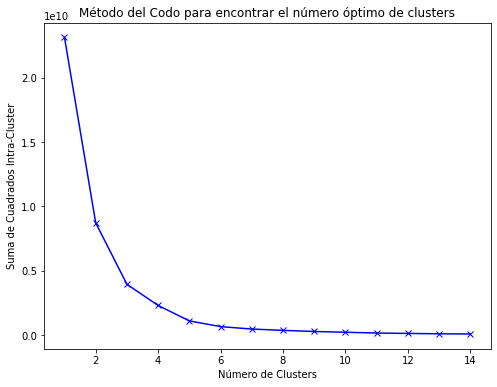

In [27]:
# Calcular la suma de cuadrados intra-cluster para diferentes valores de k
ssq = []
K = range(1, 15)  # Probamos hasta 10 clusters
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(final_df)
    ssq.append(kmeans.inertia_)

# Graficar la suma de cuadrados intra-cluster en función del número de clusters
plt.figure(figsize=(8, 6))
plt.plot(K, ssq, 'bx-')
plt.xlabel('Número de Clusters')
plt.ylabel('Suma de Cuadrados Intra-Cluster')
plt.title('Método del Codo para encontrar el número óptimo de clusters')
plt.show()

In [28]:
# Realizar clustering
k = 6  # Número de clusters deseado
kmeans = KMeans(n_clusters=k)
clusters = kmeans.fit_predict(final_df)

/home/lumamdq/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [29]:
df_serie['Cluster_dtw_'+Semestre] = clusters

In [30]:
df_serie.head()

,periodo,product_id,tn,tn_lag_1,tn_lag_2,Cluster_dtw_4
34,201912,20001,1504.68856,1397.37231,1561.50552,1
69,201912,20002,1087.30855,1423.57739,1979.53635,1
104,201912,20003,892.50129,948.29393,1081.36645,4
139,201912,20004,637.90002,723.94206,1064.69633,4
174,201912,20005,593.24443,606.91173,996.78275,4


In [31]:
df_serie['Cluster_dtw_'+Semestre] = df_serie['Cluster_dtw_'+Semestre].astype('str')
df_serie['Cluster_dtw_'+Semestre] = np.where(df_serie['Cluster_dtw_'+Semestre] == '0', 'Cluster_0', df_serie['Cluster_dtw_'+Semestre])
df_serie['Cluster_dtw_'+Semestre] = np.where(df_serie['Cluster_dtw_'+Semestre] == '1', 'Cluster_1', df_serie['Cluster_dtw_'+Semestre])
df_serie['Cluster_dtw_'+Semestre] = np.where(df_serie['Cluster_dtw_'+Semestre] == '2', 'Cluster_2', df_serie['Cluster_dtw_'+Semestre])
df_serie['Cluster_dtw_'+Semestre] = np.where(df_serie['Cluster_dtw_'+Semestre] == '3', 'Cluster_3', df_serie['Cluster_dtw_'+Semestre])
df_serie['Cluster_dtw_'+Semestre] = np.where(df_serie['Cluster_dtw_'+Semestre] == '4', 'Cluster_4', df_serie['Cluster_dtw_'+Semestre])
df_serie['Cluster_dtw_'+Semestre] = np.where(df_serie['Cluster_dtw_'+Semestre] == '5', 'Cluster_4', df_serie['Cluster_dtw_'+Semestre])
df_serie['Cluster_dtw_'+Semestre] = df_serie['Cluster_dtw_'+Semestre].fillna('Cluster_6')
df_serie['Cluster_dtw_'+Semestre] = np.where(df_serie['Cluster_dtw_'+Semestre].isnull(), 'Cluster_6', df_serie['Cluster_dtw_'+Semestre])
df_serie.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 868 entries, 34 to 33872
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   periodo        868 non-null    int64  
 1   product_id     868 non-null    int64  
 2   tn             868 non-null    float64
 3   tn_lag_1       868 non-null    float64
 4   tn_lag_2       868 non-null    float64
 5   Cluster_dtw_4  868 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 47.5+ KB


**agrego el atributo cluster_dtw al file producto base como un nuevo feature**

In [32]:
df_final = pd.read_csv(arch_base)

In [33]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34707 entries, 0 to 34706
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   product_id                 34707 non-null  int64  
 1   periodo                    34707 non-null  int64  
 2   product_id_tn              34707 non-null  float64
 3   cero_ventas                34707 non-null  int64  
 4   cust_request_qty           34707 non-null  int64  
 5   cust_request_tn            34707 non-null  float64
 6   mes                        34707 non-null  int64  
 7   producto_estrella          34707 non-null  int64  
 8   plan_precios_cuidados      34707 non-null  int64  
 9   meses_historia_prod        34707 non-null  int64  
 10  cat1                       34707 non-null  object 
 11  cat2                       34707 non-null  object 
 12  cat3                       34707 non-null  object 
 13  sku_size                   34707 non-null  int

In [34]:
df_final = df_final.merge(df_serie[['product_id', 'Cluster_dtw_'+Semestre]], on='product_id', how='left')

In [35]:
df_final['Cluster_dtw_'+Semestre] = df_final['Cluster_dtw_'+Semestre].fillna('Cluster_6')
df_final['Cluster_dtw_'+Semestre] = np.where(df_final['Cluster_dtw_'+Semestre].isnull(), 'Cluster_6', df_final['Cluster_dtw_'+Semestre])
df_final['Cluster_dtw_'+Semestre].unique()

array(['Cluster_1', 'Cluster_4', 'Cluster_2', 'Cluster_3', 'Cluster_5',
       'Cluster_0'], dtype=object)

In [36]:
df_final.to_csv(arch_base, index=False)
df_serie.to_csv(ruta_dataset + 'dataset_clusterizado.csv', index=False)